In [ ]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
from tqdm import tqdm

/Users/jerlynlim/Documents/mscphm/sem2/5013/project/env_1/lib/python3.10/site-packages/chembl_webresource_client/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


In [10]:
#connecting to chemBL
activity = new_client.activity
assay = new_client.assay
molecule = new_client.molecule
target = new_client.target

In [12]:
kras_targets = target.filter(
    target_synonym__icontains="KRAS",
    target_type="SINGLE PROTEIN",
    organism="Homo sapiens"
)

kras_target_ids = [
    t["target_chembl_id"]
    for t in kras_targets
]

print(f"Found {len(kras_target_ids)} KRAS targets")

Found 1 KRAS targets


In [13]:
# Convert to DataFrame for inspection
df_targets = pd.DataFrame([
    {
        "target_chembl_id": t["target_chembl_id"],
        "pref_name": t["pref_name"],
        "organism": t["organism"],
        "target_type": t["target_type"],
        "uniprot_accessions": t.get("target_components", [{}])[0].get("accession")
    }
    for t in kras_targets
])

df_targets.head()

,target_chembl_id,pref_name,organism,target_type,uniprot_accessions
0,CHEMBL2189121,GTPase KRas,Homo sapiens,SINGLE PROTEIN,P01116


In [21]:
assays = assay.filter(target_chembl_id="CHEMBL2189121")
print(f"Total Assays: {len(assays)}")

Total Assays: 552


In [ ]:
#filter for those targeting G12D mutation and confidence score >= 8

candidate_assays = []

for tid in kras_target_ids:
    assays = assay.filter(target_chembl_id=tid, )
    for a in assays:
        desc = (a.get("description") or "").lower()
        if "g12d" in desc and a.get("confidence_score") >= 8:
            candidate_assays.append({
                "assay_chembl_id": a["assay_chembl_id"],
                "assay_type": a.get("assay_type"),
                "description": a.get("description")
            })

print(f"Candidate SII-P G12D assays: {len(candidate_assays)}")

Candidate SII-P G12D assays: 85


In [27]:
# Convert to DataFrame for inspection
df_assays = pd.DataFrame([
    {
        "assay_chembl_id": c["assay_chembl_id"],
        "assay_type": c["assay_type"],
        "description": c["description"]
    }
    for c in candidate_assays
])

df_assays.head()

,assay_chembl_id,assay_type,description
0,CHEMBL2089529,B,Binding affinity to K-Ras G12D mutant-GDP complex
1,CHEMBL2399317,B,Binding affinity to KRAS G12D mutant (unknown ...
2,CHEMBL4021570,B,Inhibition of biotinylated K-Ras G12D mutant (...
3,CHEMBL4021571,B,Inhibition of biotinylated K-Ras G12D mutant (...
4,CHEMBL4036886,B,Binding affinity to human N-terminal His/AVi-t...


In [8]:
#all assay types seem labelled as binding

assay_types = df_assays["assay_type"].unique()
print(assay_types)

['B']


In [9]:
descriptions = df_assays["description"].unique()
descriptions.shape

(83,)

In [10]:
#can we filter out cell based assays, non-allosteric site bindings and covalent inhibitors based on description?

for d in descriptions:
  print(d)

Binding affinity to K-Ras G12D mutant-GDP complex
Binding affinity to KRAS G12D mutant (unknown origin)
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr by TR-FRET assay
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr in presence of DTT by TR-FRET assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GDP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GTP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) assessed as

In [81]:
# Clean up the list of assays and generate a report

import re

# 1) Keywords
exclusion_keywords = [
    "cell", # exclude cellular assays
    "covalent", # exclude assays of covalent binding
]

# 1a) Whitelist (kept even if they match exclusion keywords)
keep_keywords = [
    "Binding affinity to 15N-labelled GDP bound KRas G12D mutant ( 1 to 169 residues) (unknown origin) "
    "expressed in Escherichia coli Rosetta 2 (DE3) cells by 1H/15N- HSQC spectroscopy"
]

# 2) Patterns (escape to be safe)
exclude_pattern = "|".join(map(re.escape, exclusion_keywords))
keep_pattern = "|".join(map(re.escape, keep_keywords))

# 3) Masks
matches_exclusion = df_assays["description"].str.contains(exclude_pattern, case=False, na=False)
matches_keep = df_assays["description"].str.contains(keep_pattern, case=False, na=False)

# Removed if: matches exclusion AND NOT whitelisted
removed_mask = matches_exclusion & ~matches_keep

# Whitelist overrides if: matches exclusion AND matches keep
omitted_from_exclusion_mask = matches_exclusion & matches_keep

# 4) Split
removed_df = df_assays[removed_mask].copy()
df_assays_filtered = df_assays[~removed_mask].copy()
omitted_from_exclusion_df = df_assays[omitted_from_exclusion_mask].copy()

# 5) Reason for removal (only for removed_df)
def find_trigger(text: str):
    t = (text or "").lower()
    for w in exclusion_keywords:
        if w.lower() in t:
            return w
    return None

removed_df["reason_for_removal"] = removed_df["description"].apply(find_trigger)

# 6) Print summary
print(f"Kept: {len(df_assays_filtered)} | Removed: {len(removed_df)} | Omitted from exclusion (whitelist override): {len(omitted_from_exclusion_df)}\n")

# 7) Print omitted-from-exclusion items (whitelist overrides)
if len(omitted_from_exclusion_df) > 0:
    print("--- OMITTED FROM EXCLUSION (WHITELIST OVERRIDE) ---\n")
    for _, row in omitted_from_exclusion_df.iterrows():
        print(f"DESCRIPTION: {row['description']}")
        print("-" * 30)

# 8) Print removed items
print(f"\n--- TOTAL REMOVED: {len(removed_df)} ---\n")
for _, row in removed_df.iterrows():
    reason = row["reason_for_removal"] or "UNKNOWN"
    print(f"REMOVED BY: [{reason.upper()}]")
    print(f"DESCRIPTION: {row['description']}")
    print("-" * 30)

Kept: 63 | Removed: 22 | Omitted from exclusion (whitelist override): 1

--- OMITTED FROM EXCLUSION (WHITELIST OVERRIDE) ---

DESCRIPTION: Binding affinity to 15N-labelled GDP bound KRas G12D mutant ( 1 to 169 residues) (unknown origin) expressed in Escherichia coli Rosetta 2 (DE3) cells by 1H/15N- HSQC spectroscopy
------------------------------

--- TOTAL REMOVED: 22 ---

REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRAS G12D mutant in human AGS cells assessed as reduction in ERK phosphorylation measured after 3 hrs by Western blot analysis
------------------------------
REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRas G12D mutant (unknown origin) expressed in HEK293T cells coexpressing GFP-fused CRAF RBD assessed as reduction in Ras-Raf interaction using coelenterazine 400a as substrate incubated for 20 hrs by BRET2 assay
------------------------------
REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRas G12D mutant (unknown origin) expressed in HEK293T cells coexpressing GFP-fused

In [83]:
descriptions_filtered = df_assays_filtered["description"].unique()
descriptions_filtered.shape

(63,)

In [ ]:
import pandas as pd
import numpy as np

# Convert NumPy array to DataFrame
df = pd.DataFrame(descriptions_filtered, columns=["Description"])  # change column name if needed

# Export to CSV
df.to_csv("data/descriptions_filtered.csv", index=False)

In [89]:
df_assays_filtered.head()

,assay_chembl_id,assay_type,description
0,CHEMBL2089529,B,Binding affinity to K-Ras G12D mutant-GDP complex
1,CHEMBL2399317,B,Binding affinity to KRAS G12D mutant (unknown ...
2,CHEMBL4021570,B,Inhibition of biotinylated K-Ras G12D mutant (...
3,CHEMBL4021571,B,Inhibition of biotinylated K-Ras G12D mutant (...
4,CHEMBL4036886,B,Binding affinity to human N-terminal His/AVi-t...


In [101]:
activities_query = activity.filter(
    assay_chembl_id__in=df_assays_filtered["assay_chembl_id"].unique().tolist(),
    standard_type__in = ["IC50", "Kd", "k_off", "kon"],
    standard_relation='='  # Exact measurements only, no inequalities
).only([
    'molecule_chembl_id',
    'canonical_smiles',
    'standard_value',
    'standard_units',
    'standard_type',
    'pchembl_value',
    'assay_chembl_id',
    'assay_description',
    'document_chembl_id'
])


In [102]:
total_count = len(activities_query)
print(f'Total records found on server: {total_count}')

activity_list = []
for act in tqdm(activities_query, total=total_count, desc="Fetching ChEMBL Data"):
  activity_list.append(act)

df_activities = pd.DataFrame(activity_list)
csv_filename = "data/KRAS_G12D_chemBL_raw.csv"
df_activities.to_csv(csv_filename, index=False)
print(f'\nDownload complete!')
print(f'Total records saved: {len(df_activities)}')
if not df_activities.empty:
  print(f'Types of measurements found: {df_activities["standard_type"].unique()}')

Total records found on server: 3025


Fetching ChEMBL Data: 100%|██████████| 3025/3025 [02:43<00:00, 18.45it/s]


Download complete!
Total records saved: 3025
Types of measurements found: ['Kd' 'IC50' 'kon' 'k_off']


In [115]:
import pandas as pd
df_activities = pd.read_csv("data/KRAS_G12D_chemBL_raw.csv")

In [116]:
#drop rows with no values
df_activities = df_activities.dropna(subset=['standard_value', 'canonical_smiles'])
# Check counts again (standard_type, standard_units) after filtering
df_activities[["standard_type", "standard_units"]].value_counts()

standard_type  standard_units
IC50           nM                871
Kd             nM                182
Name: count, dtype: int64

In [129]:
df_activities_Kd = df_activities[(df_activities["standard_type"] == "Kd") & (df_activities["standard_value"] > 0) ]
df_activities_Kd = df_activities_Kd.copy()
df_activities_Kd['pKd'] = 9 - np.log10(df_activities_Kd['standard_value'].copy().astype(float))

print(f"\npKd Statistics:")
print(f"  Mean: {df_activities_Kd['pKd'].mean():.2f}")
print(f"  Std:  {df_activities_Kd['pKd'].std():.2f}")
print(f"  Min:  {df_activities_Kd['pKd'].min():.2f}")
print(f"  Max:  {df_activities_Kd['pKd'].max():.2f}")

print(f"No. of unique compounds: {df_activities_Kd['canonical_smiles'].nunique()}")


pKd Statistics:
  Mean: 6.53
  Std:  1.64
  Min:  2.89
  Max:  10.00
No. of unique compounds: 169


In [132]:
df_activities_IC50 = df_activities[(df_activities["standard_type"] == "IC50") & (df_activities["standard_value"] > 0) ]
df_activities_IC50 = df_activities_IC50.copy()
df_activities_IC50['pIC50'] = 9 - np.log10(df_activities_IC50['standard_value'].astype(float))

print(f"\npIC50 Statistics:")
print(f"  Mean: {df_activities_IC50['pIC50'].mean():.2f}")
print(f"  Std:  {df_activities_IC50['pIC50'].std():.2f}")
print(f"  Min:  {df_activities_IC50['pIC50'].min():.2f}")
print(f"  Max:  {df_activities_IC50['pIC50'].max():.2f}")

print(f"No. of unique compounds: {df_activities_IC50['canonical_smiles'].nunique()}")


pIC50 Statistics:
  Mean: 6.69
  Std:  1.39
  Min:  4.13
  Max:  10.00
No. of unique compounds: 540


In [ ]:
# Step 1: Identify duplicate groups
duplicate_groups = df_activities_IC50.groupby('canonical_smiles').filter(lambda x: len(x) > 1)
unique_smiles_with_dups = duplicate_groups['canonical_smiles'].nunique()

print(f"Compounds with multiple measurements: {unique_smiles_with_dups:,}")
print(f"Total rows involved in duplicates: {len(duplicate_groups):,}")

# Step 2: Create a report of merged/dropped molecules
duplicate_report = df_activities_IC50.groupby('canonical_smiles').agg({
    'molecule_chembl_id': list,  # All ChEMBL IDs that share this SMILES
    'pIC50': list,               # All pIC50 values
    'standard_value': list,      # All IC50 values
}).reset_index()


Compounds with multiple measurements: 271
Total rows involved in duplicates: 602


In [136]:
# Filter to only show compounds that had duplicates
duplicate_report['n_measurements'] = duplicate_report['molecule_chembl_id'].apply(len)
dropped_molecules_report = duplicate_report[duplicate_report['n_measurements'] > 1].copy()
dropped_molecules_report.head()

,canonical_smiles,molecule_chembl_id,pIC50,standard_value,n_measurements
0,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,"[CHEMBL5930957, CHEMBL5930957]","[8.795880017344075, 5.130650919240907]","[1.6, 7402.0]",2
1,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)n...,"[CHEMBL4867851, CHEMBL4867851, CHEMBL4867851]","[9.221848749616356, 9.221848749616356, 7.81815...","[0.6, 0.6, 15.2]",3
2,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)n...,"[CHEMBL4858364, CHEMBL4858364, CHEMBL4858364]","[9.397940008672037, 9.397940008672037, 9.09691...","[0.4, 0.4, 0.8]",3
3,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)n...,"[CHEMBL5977600, CHEMBL5977600]","[9.096910013008056, 8.075720713938118]","[0.8, 8.4]",2
4,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CCCC6(CCO6)C5)...,"[CHEMBL5273122, CHEMBL5273122]","[9.0, 9.0]","[1.0, 1.0]",2


In [143]:
# Add summary stats
dropped_molecules_report['pIC50_range'] = dropped_molecules_report['pIC50'].apply(lambda x: max(x) - min(x))
dropped_molecules_report['kept_chembl_id'] = dropped_molecules_report['molecule_chembl_id'].apply(lambda x: x[0])
dropped_molecules_report['dropped_chembl_ids'] = dropped_molecules_report['molecule_chembl_id'].apply(lambda x: x[1:] if len(x) > 1 else [])
dropped_molecules_report.sort_values("pIC50_range", ascending=False).head()

,canonical_smiles,molecule_chembl_id,pIC50,standard_value,n_measurements,pIC50_range,kept_chembl_id,dropped_chembl_ids
504,Oc1cc(-c2ncc3c(N4CC5CCC(C4)N5)nc(OC[C@@H]4CCCN...,"[CHEMBL6051701, CHEMBL6051701]","[8.602059991327963, 4.812366490049307]","[2.5, 15404.0]",2,3.789694,CHEMBL6051701,[CHEMBL6051701]
122,CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34C...,"[CHEMBL5873176, CHEMBL5873176]","[8.823908740944319, 5.116849800316722]","[1.5, 7641.0]",2,3.707059,CHEMBL5873176,[CHEMBL5873176]
0,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,"[CHEMBL5930957, CHEMBL5930957]","[8.795880017344075, 5.130650919240907]","[1.6, 7402.0]",2,3.665229,CHEMBL5930957,[CHEMBL5930957]
482,Oc1cc(-c2ncc3c(N4CC5CCC(C4)N5)nc(OCC45CCCN4C(C...,"[CHEMBL4855757, CHEMBL4855757, CHEMBL4855757]","[10.0, 8.619788758288394, 6.400116927926312]","[0.1, 2.4, 398.0]",3,3.599883,CHEMBL4855757,"[CHEMBL4855757, CHEMBL4855757]"
442,OCC1CCC2(COc3nc(N4CC5CCC(C4)N5)c4cnc(-c5cccc6c...,"[CHEMBL6040959, CHEMBL6040959]","[8.67778070526608, 5.316862868516993]","[2.1, 4821.0]",2,3.360918,CHEMBL6040959,[CHEMBL6040959]


In [138]:
# Step 3: Save the duplicate report
report_filename = 'data/REPORT_ic50_duplicate_dropped_molecules.csv'
dropped_molecules_report.to_csv(report_filename, index=False)
print(f"\nSaved duplicate report to {report_filename}")


Saved duplicate report to data/REPORT_ic50_duplicate_dropped_molecules.csv


In [144]:
#remove compounds with pIC50 range >= 2

print(f"Before exclusion: {df_activities_IC50['canonical_smiles'].nunique()}")
excluded_compounds = dropped_molecules_report[dropped_molecules_report["pIC50_range"] >= 2]["canonical_smiles"]
print(len(excluded_compounds))
df_activities_IC50 = df_activities_IC50[~df_activities_IC50["canonical_smiles"].isin(excluded_compounds)]
print(f"After exclusion: {df_activities_IC50['canonical_smiles'].nunique()}")

Before exclusion: 540
117
After exclusion: 423


In [ ]:
df_activities_IC50['standard_value'] = df_activities_IC50['standard_value'].astype(float)
df_aggregated = df_activities_IC50.groupby('canonical_smiles').agg({
    'molecule_chembl_id': 'first',
    'pIC50': 'median',
    'standard_value': 'median',
}).reset_index()

print(f"\nUnique compounds after aggregation: {len(df_aggregated):,}")



Unique compounds after aggregation: 423


In [146]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

# Step 1: Calculate Morgan fingerprints for similarity analysis
def get_morgan_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

# Step 2: Generate fingerprints (this may take a moment)
print("Generating fingerprints for activity cliff analysis...")
df_aggregated['fp'] = df_aggregated['canonical_smiles'].apply(get_morgan_fp)
df_valid = df_aggregated.dropna(subset=['fp']).copy()
print(f"Compounds with valid fingerprints: {len(df_valid):,}")

# Step 3: Sample-based activity cliff detection
# Full pairwise comparison is O(n^2); we sample for efficiency
n_samples = min(1000, len(df_valid))
sample_idx = np.random.choice(len(df_valid), n_samples, replace=False)
sample_df = df_valid.iloc[sample_idx]

cliff_pairs = []
fps = list(sample_df['fp'])
pic50s = list(sample_df['pIC50'])

for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        # Calculate Tanimoto similarity
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        # Activity cliff: high similarity (>0.85) but large pIC50 difference (>2)
        if sim > 0.85 and abs(pic50s[i] - pic50s[j]) > 2:
            cliff_pairs.append((i, j, sim, abs(pic50s[i] - pic50s[j])))

print(f"\nActivity cliffs detected (in sample): {len(cliff_pairs)}")
if cliff_pairs:
    print("These represent challenging cases for QSAR prediction.")


Generating fingerprints for activity cliff analysis...
Compounds with valid fingerprints: 423

Activity cliffs detected (in sample): 50
These represent challenging cases for QSAR prediction.


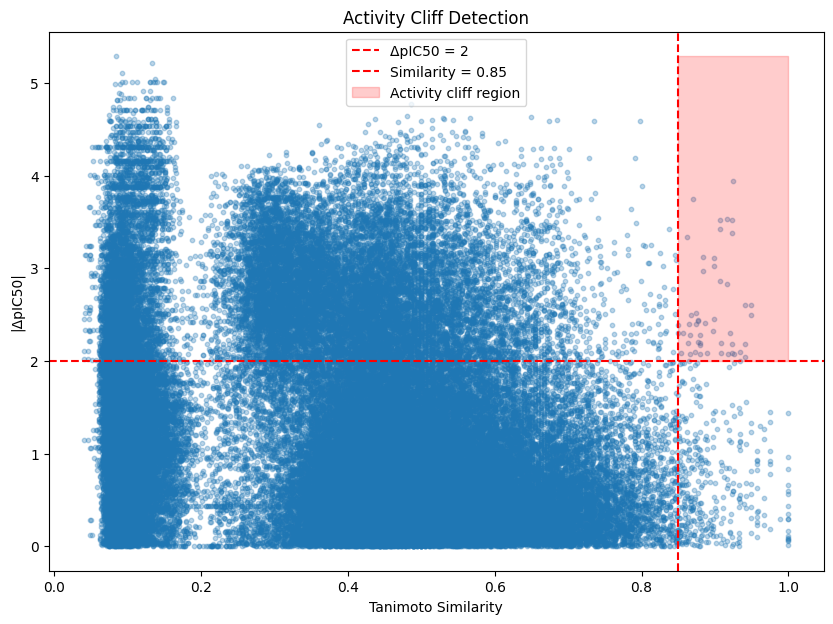

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate all pairwise similarities and activity differences (sampled)
sim_list, delta_pic50_list = [], []

for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        delta = abs(pic50s[i] - pic50s[j])
        sim_list.append(sim)
        delta_pic50_list.append(delta)

plt.figure(figsize=(10, 7))
plt.scatter(sim_list, delta_pic50_list, alpha=0.3, s=10)
plt.axhline(y=2, color='red', linestyle='--', label='ΔpIC50 = 2')
plt.axvline(x=0.85, color='red', linestyle='--', label='Similarity = 0.85')
plt.fill_between([0.85, 1.0], 2, max(delta_pic50_list), alpha=0.2, color='red', label='Activity cliff region')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('|ΔpIC50|')
plt.title('Activity Cliff Detection')
plt.legend()
plt.show()


In [148]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
from tqdm import tqdm

# Careful when using this. This suppresses all warnings from RDKit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize standardization tools
salt_remover = SaltRemover()
uncharger = rdMolStandardize.Uncharger()
normalizer = rdMolStandardize.Normalizer()
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

def standardize_molecule(smiles):
    """
    Apply publication-grade molecular standardization.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        # Remove salts (keep largest fragment)
        mol = salt_remover.StripMol(mol)

        # Normalize functional groups
        mol = normalizer.normalize(mol)

        # Neutralize charges
        mol = uncharger.uncharge(mol)

        # Canonicalize tautomers
        mol = tautomer_enumerator.Canonicalize(mol)

        # Return canonical SMILES
        return Chem.MolToSmiles(mol, canonical=True)

    except Exception:
        return None

# Apply standardization with progress bar
print("Standardizing molecular structures...")
df_valid['smiles_standardized'] = df_valid['canonical_smiles'].progress_apply(standardize_molecule)

n_before = len(df_valid)
df_curated = df_valid.dropna(subset=['smiles_standardized']).copy()
n_after = len(df_curated)
print(f"Standardization complete: {n_after:,} / {n_before:,} compounds retained")


Standardizing molecular structures...


100%|██████████| 423/423 [02:10<00:00,  3.23it/s] 

Standardization complete: 423 / 423 compounds retained


In [153]:
df_curated.groupby('smiles_standardized').filter(lambda x: len(x) > 1).head()

,canonical_smiles,molecule_chembl_id,pIC50,standard_value,fp,smiles_standardized
71,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,CHEMBL4082777,7.835301,20.55,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CC[C@H](C)C1NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(CC(C)...
80,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,CHEMBL4072295,7.928180,44.30,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CC[C@H](C)C1NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(CC(C)...


In [ ]:
# Check for duplicates after standardization
n_unique_before = df_curated['smiles_standardized'].nunique()
n_total = len(df_curated)

print(f"Total entries: {n_total:,}")
print(f"Unique standardized SMILES: {n_unique_before:,}")
print(f"New duplicates revealed: {n_total - n_unique_before:,}")

# Aggregate duplicates by taking median pIC50
df_final = df_curated.groupby('smiles_standardized').agg(
    molecule_chembl_id=('molecule_chembl_id', 'first'),
    pIC50=('pIC50', 'median')
).reset_index()

df_final = df_final.rename(columns={'smiles_standardized': 'smiles'})
print(f"\nFinal curated dataset: {len(df_final):,} unique compounds")


Total entries: 423
Unique standardized SMILES: 422
New duplicates revealed: 1

Final curated dataset: 422 unique compounds


In [154]:
import requests

# Analyze stereochemistry in the dataset
tqdm.pandas(desc="Counting stereocenters")

def count_stereocenters(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    return len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))

def has_undefined_stereo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return any(c[1] == '?' for c in centers)

# Analyze the dataset
df_final['n_stereocenters'] = df_final['smiles'].progress_apply(count_stereocenters)

tqdm.pandas(desc="Checking undefined stereo")
df_final['undefined_stereo'] = df_final['smiles'].progress_apply(has_undefined_stereo)

n_with_stereo = (df_final['n_stereocenters'] > 0).sum()
n_undefined = df_final['undefined_stereo'].sum()

print(f"Compounds with stereocenters: {n_with_stereo:,}")
print(f"Compounds with undefined stereochemistry: {n_undefined:,}")

# Query ChEMBL for original structures to resolve undefined stereochemistry
def batch_query_chembl(chembl_ids, batch_size=50):
    """Batch query ChEMBL for molfiles with better stereo annotation."""
    results = {}

    for i in tqdm(range(0, len(chembl_ids), batch_size), desc="Querying ChEMBL"):
        batch = chembl_ids[i:i+batch_size]
        ids_str = ";".join(batch)
        url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/set/{ids_str}.sdf"

        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                suppl = Chem.SDMolSupplier()
                suppl.SetData(response.text)
                for mol in suppl:
                    if mol and mol.HasProp('chembl_id'):
                        cid = mol.GetProp('chembl_id')
                        results[cid] = Chem.MolToSmiles(mol, isomericSmiles=True)
        except Exception as e:
            continue

    return results

if n_undefined > 0:
    print(f"\nQuerying ChEMBL for {n_undefined:,} compounds with undefined stereochemistry...")
    undefined_ids = df_final[df_final['undefined_stereo']]['molecule_chembl_id'].tolist()
    updated_smiles = batch_query_chembl(undefined_ids)

    # Update SMILES where ChEMBL returned a structure
    df_final['smiles'] = df_final.apply(
        lambda row: updated_smiles.get(row['molecule_chembl_id'], row['smiles']), axis=1
    )

    # Re-check undefined stereo after update
    tqdm.pandas(desc="Re-checking undefined stereo")
    df_final['undefined_stereo'] = df_final['smiles'].progress_apply(has_undefined_stereo)

    n_still_undefined = df_final['undefined_stereo'].sum()
    n_resolved = n_undefined - n_still_undefined

    print(f"\nStereochemistry resolved for {n_resolved:,} compounds")
    print(f"Still undefined: {n_still_undefined:,} compounds")
else:
    print("\nNo undefined stereochemistry to resolve.")


Checking undefined stereo: 100%|██████████| 422/422 [00:00<00:00, 761.39it/s]


Compounds with stereocenters: 410
Compounds with undefined stereochemistry: 392

Querying ChEMBL for 392 compounds with undefined stereochemistry...


Re-checking undefined stereo: 100%|██████████| 422/422 [00:00<00:00, 1057.92it/s]


Stereochemistry resolved for 0 compounds
Still undefined: 392 compounds


Majority of compounds have undefined stereochemistry, so we will use stereo-agnostic descriptors later on for modelling.

In [155]:
# Generate quality control summary
print("=" * 60)
print("DATA CURATION SUMMARY")
print("=" * 60)
print(f"Target: KRAS G12D mutation (CHEMBL2189121)")
print(f"Endpoint: pIC50 (derived from IC50, nM)")
print(f"")
print(f"Dataset Statistics:")
print(f"  Total compounds: {len(df_final):,}")
print(f"  pIC50 range: {df_final['pIC50'].min():.2f} - {df_final['pIC50'].max():.2f}")
print(f"  pIC50 mean: {df_final['pIC50'].mean():.2f} ± {df_final['pIC50'].std():.2f}")

# Save curated dataset
output_file = 'data/DATASET_ic50_cleaned_compounds.csv'
df_final.to_csv(output_file, index=False)
print(f"\nSaved: {output_file}")


DATA CURATION SUMMARY
Target: KRAS G12D mutation (CHEMBL2189121)
Endpoint: pIC50 (derived from IC50, nM)

Dataset Statistics:
  Total compounds: 422
  pIC50 range: 4.41 - 9.70
  pIC50 mean: 6.57 ± 1.17

Saved: data/DATASET_ic50_cleaned_compounds.csv


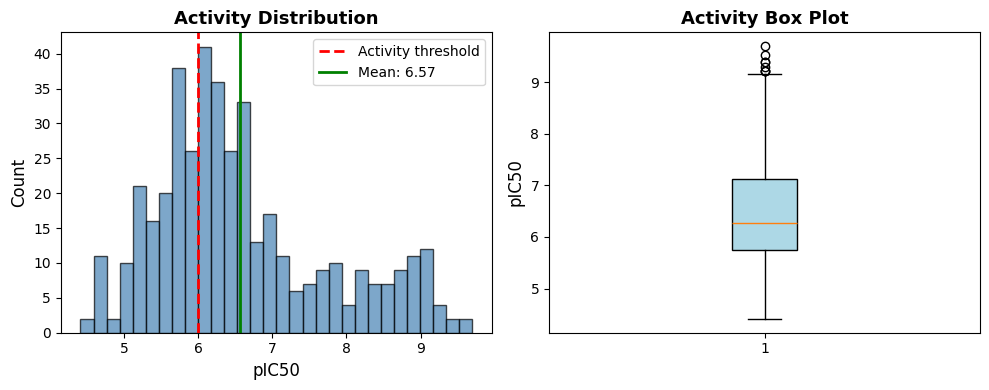

In [1]:
# ============================================================
# ACTIVITY DISTRIBUTION VISUALIZATION
# ============================================================
import pandas as pd

df_final = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax1 = axes[0]
ax1.hist(df_final["pIC50"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=6, color='red', linestyle='--', linewidth=2, label='Activity threshold')
ax1.axvline(x=df_final["pIC50"].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {df_final["pIC50"].mean():.2f}')
ax1.set_xlabel('pIC50', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Activity Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(df_final["pIC50"], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('pIC50', fontsize=12)
ax2.set_title('Activity Box Plot', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from tqdm import tqdm
import numpy as np

df = df_final

# Enable tqdm for pandas
tqdm.pandas()

def generate_morgan_fingerprint(mol, radius=2, n_bits=2048):
    """
    Generate Morgan (ECFP) fingerprint as a bit vector.

    Parameters:
    - radius: 2 gives ECFP4, 3 gives ECFP6
    - n_bits: fingerprint length (2048 is standard)

    Returns numpy array of shape (n_bits,)
    """
    if mol is None:
        return None

    # Use the new MorganGenerator API
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = generator.GetFingerprintAsNumPy(mol)
    return fp

# Create RDKit Mol objects from SMILES
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

# Check for any failures
n_failed = df['mol'].isna().sum()
print(f"Successfully converted: {len(df) - n_failed} | Failed: {n_failed}")

# Drop any rows where conversion failed
if n_failed > 0:
    df = df.dropna(subset=['mol']).reset_index(drop=True)

# Generate ECFP4 fingerprints for all compounds
print("Generating Morgan/ECFP4 fingerprints (radius=2, 2048 bits)...")
ecfp4_fps = df['mol'].progress_apply(lambda m: generate_morgan_fingerprint(m, radius=2, n_bits=2048))

# Convert to DataFrame with meaningful column names
ecfp4_matrix = np.vstack(ecfp4_fps.values)
ecfp4_columns = [f'ECFP4_{i}' for i in range(2048)]
df_ecfp4 = pd.DataFrame(ecfp4_matrix, columns=ecfp4_columns, index=df.index)

print(f"ECFP4 fingerprint matrix shape: {df_ecfp4.shape}")
print(f"Bits set per molecule (mean): {ecfp4_matrix.sum(axis=1).mean():.1f}")

Successfully converted: 422 | Failed: 0
Generating Morgan/ECFP4 fingerprints (radius=2, 2048 bits)...


100%|██████████| 422/422 [00:00<00:00, 4618.37it/s]

ECFP4 fingerprint matrix shape: (422, 2048)
Bits set per molecule (mean): 76.6


In [3]:
from rdkit.Chem import MACCSkeys

tqdm.pandas()

def generate_maccs_fingerprint(mol):
    """
    Generate MACCS keys fingerprint (166 bits).

    MACCS keys are predefined structural patterns.
    Each bit has a known chemical interpretation.
    """
    if mol is None:
        return None
    fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(fp)

# Generate MACCS fingerprints for all compounds
print("Generating MACCS key fingerprints (166 bits)...")
maccs_fps = df['mol'].progress_apply(generate_maccs_fingerprint)

# Convert to DataFrame
maccs_matrix = np.vstack(maccs_fps.values)
maccs_columns = [f'MACCS_{i}' for i in range(167)]  # MACCS has 167 bits (0-166)
df_maccs = pd.DataFrame(maccs_matrix, columns=maccs_columns, index=df.index)

print(f"MACCS fingerprint matrix shape: {df_maccs.shape}")
print(f"Bits set per molecule (mean): {maccs_matrix.sum(axis=1).mean():.1f}")


Generating MACCS key fingerprints (166 bits)...


100%|██████████| 422/422 [00:02<00:00, 165.33it/s]

MACCS fingerprint matrix shape: (422, 167)
Bits set per molecule (mean): 69.6


In [4]:
from rdkit.Chem import RDKFingerprint

# Enable tqdm for pandas
tqdm.pandas()

def generate_rdkit_fingerprint(mol, n_bits=2048):
    """
    Generate RDKit topological fingerprint.

    Encodes hashed paths through the molecular graph.
    Complementary to circular fingerprints like ECFP.
    """
    if mol is None:
        return None
    fp = RDKFingerprint(mol, fpSize=n_bits)
    return np.array(fp)

# Generate RDKit fingerprints for all compounds
print("Generating RDKit topological fingerprints (2048 bits)...")
rdkit_fps = df['mol'].progress_apply(lambda m: generate_rdkit_fingerprint(m, n_bits=2048))

# Convert to DataFrame
rdkit_matrix = np.vstack(rdkit_fps.values)
rdkit_columns = [f'RDKit_{i}' for i in range(2048)]
df_rdkit = pd.DataFrame(rdkit_matrix, columns=rdkit_columns, index=df.index)

print(f"RDKit fingerprint matrix shape: {df_rdkit.shape}")
print(f"Bits set per molecule (mean): {rdkit_matrix.sum(axis=1).mean():.1f}")


Generating RDKit topological fingerprints (2048 bits)...


100%|██████████| 422/422 [00:04<00:00, 91.11it/s] 

RDKit fingerprint matrix shape: (422, 2048)
Bits set per molecule (mean): 1380.9


In [5]:
import numpy as np

# Fix for deprecated np.float
if not hasattr(np, 'float'):
    np.float = float

In [7]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

rdkit_names = [desc[0] for desc in Descriptors._descList]
calc_rdkit = MoleculeDescriptors.MolecularDescriptorCalculator(rdkit_names)
calc_mordred = Calculator(descriptors, ignore_3D=True)
mordred_names = [str(d) for d in calc_mordred.descriptors]

def calculate_descriptors_rdkit(mol):
    if mol is None:
        return [np.nan] * len(rdkit_names)
    try:
        return list(calc_rdkit.CalcDescriptors(mol))
    except Exception as e:
        print(e)
        return [np.nan] * len(rdkit_names)

def calculate_descriptors_mordred(mol):
    if mol is None:
        return [np.nan] * len(mordred_names)
    try:
        return list(calc_mordred(mol))
    except Exception as e:
        print(e)
        return [np.nan] *len(mordred_names)

descriptors_RDKit = df['mol'].progress_apply(calculate_descriptors_rdkit)
descriptors_Mordred = df['mol'].progress_apply(calculate_descriptors_mordred)

print("Calculating RDKit descriptors...")
df_descriptors_RDKit = pd.DataFrame(
    list(descriptors_RDKit),
    columns=rdkit_names,
    index=df.index
)

print("Calculating Mordred descriptors...")
df_descriptors_Mordred = pd.DataFrame(
    list(descriptors_Mordred),
    columns=mordred_names,
    index=df.index
)

print(f"Descriptor matrix shape (RDKit): {df_descriptors_RDKit.shape}")
print(f"Descriptor matrix shape (Mordred): {df_descriptors_Mordred.shape}")

  3%|▎         | 13/422 [00:06<03:08,  2.17it/s]/Users/jerlynlim/Documents/mscphm/sem2/5013/project/env_1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 422/422 [04:01<00:00,  1.75it/s]

Calculating RDKit descriptors...
Calculating Mordred descriptors...
Descriptor matrix shape (RDKit): (422, 217)
Descriptor matrix shape (Mordred): (422, 1613)


In [8]:
df_descriptors_RDKit.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,16.723926,16.723926,0.019051,-0.703924,0.326166,22.767442,582.655,550.399,582.255481,220,...,0,0,0,1,0,0,0,0,0,0
1,16.725593,16.725593,0.007777,-0.912746,0.319044,26.409091,600.645,569.397,600.246059,226,...,0,0,0,1,0,0,0,0,0,0
2,16.937084,16.937084,0.010840,-0.752284,0.262843,24.460000,683.760,644.448,683.303159,260,...,0,0,0,1,0,0,0,0,0,0
3,16.776945,16.776945,0.011704,-0.921365,0.294003,26.355556,615.656,583.400,615.245725,232,...,0,0,0,1,0,0,0,0,0,0
4,16.725593,16.725593,0.007777,-0.912746,0.319044,26.409091,600.645,569.397,600.246059,226,...,0,0,0,1,0,0,0,0,0,0


In [9]:
df_descriptors_Mordred.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,35.217498,26.242057,0,2,57.590791,2.549354,5.092256,57.590791,1.339321,4.737836,...,11.009423,98.654464,582.255481,7.763406,6091,81,252.0,313.0,11.340278,9.069444
1,36.033994,26.712058,0,2,58.559962,2.550952,5.093865,58.559962,1.330908,4.759464,...,11.034615,99.884265,600.246059,8.003281,6495,83,258.0,320.0,12.201389,9.236111
2,40.414534,29.694478,0,2,65.849899,2.553447,5.096386,65.849899,1.316998,4.873723,...,11.103528,106.346037,683.303159,7.677564,9682,93,286.0,352.0,14.923611,10.625000
3,36.741101,27.151726,0,1,59.213517,2.553815,5.103996,59.213517,1.315856,4.783701,...,11.135975,100.066645,615.245725,7.990204,6899,85,264.0,328.0,12.541667,9.486111
4,36.033994,26.712058,0,2,58.559962,2.550952,5.093865,58.559962,1.330908,4.759464,...,11.034615,99.884265,600.246059,8.003281,6495,83,258.0,320.0,12.201389,9.236111


In [10]:
# Step 1: Create metadata columns
df_metadata = df[['molecule_chembl_id', 'smiles', 'pIC50']].copy()

# Step 2: Combine all fingerprints
df_fingerprints_combined = pd.concat([
    df_metadata.reset_index(drop=True),
    df_ecfp4.reset_index(drop=True),
    df_maccs.reset_index(drop=True),
    df_rdkit.reset_index(drop=True)
], axis=1)

# Step 3: Also create individual fingerprint files for comparison studies
df_ecfp4_final = pd.concat([df_metadata.reset_index(drop=True), df_ecfp4.reset_index(drop=True)], axis=1)
df_maccs_final = pd.concat([df_metadata.reset_index(drop=True), df_maccs.reset_index(drop=True)], axis=1)
df_rdkit_final = pd.concat([df_metadata.reset_index(drop=True), df_rdkit.reset_index(drop=True)], axis=1)


In [15]:
# Assemble descriptor dataset

df_descriptors_RDKit = df_descriptors_RDKit.replace([np.inf, -np.inf], np.nan)
df_descriptors_Mordred = df_descriptors_Mordred.replace([np.inf, -np.inf], np.nan)
df_descriptors_Mordred = df_descriptors_Mordred.apply(pd.to_numeric, errors='coerce')
df_descriptors_Mordred = df_descriptors_Mordred.dropna(axis=1, how='all')

df_descriptors_rdkit_dataset = pd.concat([
    df_metadata.reset_index(drop=True),
    df_descriptors_RDKit.reset_index(drop=True)
], axis=1)

df_descriptors_mordred_dataset = pd.concat([
    df_metadata.reset_index(drop=True),
    df_descriptors_Mordred.reset_index(drop=True)
], axis=1)

print(f"Descriptor dataset shape (RDKit): {df_descriptors_rdkit_dataset.shape}")
print(f"Descriptor dataset shape (Mordred): {df_descriptors_mordred_dataset.shape}")
print(f"  - Metadata columns: 3")
print(f"  - Descriptor features (RDKit): {df_descriptors_RDKit.shape[1]}")
print(f"  - Descriptor features (Mordred): {df_descriptors_Mordred.shape[1]}")


Descriptor dataset shape (RDKit): (422, 220)
Descriptor dataset shape (Mordred): (422, 1508)
  - Metadata columns: 3
  - Descriptor features (RDKit): 217
  - Descriptor features (Mordred): 1505


In [16]:
# Save all feature matrices
print("Saving feature matrices...")

# Combined fingerprints
df_fingerprints_combined.to_csv('data/DATASET_fp_combined.csv', index=False)
print(f"  Saved: DATASET_fp_combined.csv ({df_fingerprints_combined.shape})")

# Individual fingerprint types (for comparative studies)
df_ecfp4_final.to_csv('data/DATASET_ecfp4.csv', index=False)
print(f"  Saved: DATASET_ecfp4.csv ({df_ecfp4_final.shape})")

df_maccs_final.to_csv('data/DATASET_maccs.csv', index=False)
print(f"  Saved: DATASET_maccs.csv ({df_maccs_final.shape})")

df_rdkit_final.to_csv('data/DATASET_rdkit.csv', index=False)
print(f"  Saved: DATASET_rdkit.csv ({df_rdkit_final.shape})")

# Molecular descriptors
df_descriptors_rdkit_dataset.to_csv('data/DATASET_descriptors_rdkit.csv', index=False)
print(f"  Saved: DATASET_descriptors_rdkit.csv ({df_descriptors_rdkit_dataset.shape})")

df_descriptors_mordred_dataset.to_csv('data/DATASET_descriptors_mordred.csv', index=False)
print(f"  Saved: DATASET_descriptors_mordred.csv ({df_descriptors_mordred_dataset.shape})")

print("\nAll feature matrices saved successfully.")

Saving feature matrices...
  Saved: DATASET_fp_combined.csv ((422, 4266))
  Saved: DATASET_ecfp4.csv ((422, 2051))
  Saved: DATASET_maccs.csv ((422, 170))
  Saved: DATASET_rdkit.csv ((422, 2051))
  Saved: DATASET_descriptors_rdkit.csv ((422, 220))
  Saved: DATASET_descriptors_mordred.csv ((422, 1508))

All feature matrices saved successfully.
